**Dataset**
labeled datasset collected from twitter

**Objective**
classify tweets containing hate speech from other tweets. <br>
0 -> no hate speech <br>
1 -> contains hate speech <br>

**Evaluation metric**
macro f1 score

> **Load the `clean data` preprocessed in `Assignment 1`, then handle it to be used with `RNNs`**

### Global Variables :

In [2]:
RANDOM_STATE = 42

### Import Libraries

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# NLTK and spacy for text
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk
# import spacy
# nlp = spacy.load('en_core_web_lg')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Set pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)


2025-04-25 04:38:31.879291: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 04:38:32.097495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745545112.176742   25240 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745545112.200777   25240 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745545112.376079   25240 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
np.random.seed(RANDOM_STATE)

### Load Dataset

In [5]:
df = pd.read_csv("/home/israa/Desktop/NLP_Projects/Assignment_1/Hate Speech.tsv", sep="\t", index_col='id')
df.head(30)

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
3,0,bihday your majesty
4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
5,0,factsguide: society now #motivation
6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦


In [6]:
df_copy = df.copy()

Insights from the data to determine the preprossing needed:

- mentions like @user
- `#` remove
- punctiuations 
- non words like ±!!! ððð (non ascii)
- things like [2/2]
- remove numbers 


In the case of # we have 2 options :
- remove the whole # with the word after it 
- remove the # sign only 

In our case Because hashtags often hold valuable meaning (e.g., #gold, #forex, #michigan) so it can make difference.



In [44]:
X = df.drop(columns=['label'])
y = df['label']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [45]:
# train_compined = pd.concat([x_train, y_train], axis=1)
# train_compined = train_compined.reset_index(drop=True)

In [46]:
# # Apply SMOTE only on training data
# sm = SMOTE(random_state=42)
# # X_train_res, y_train_res = sm.fit_resample(x_train, y_train)

In [47]:
train_combined = pd.concat([x_train, y_train], axis=1)
test_combined = pd.concat([x_test, y_test], axis=1)

In [55]:
train_combined.drop_duplicates(inplace=True)
test_combined.drop_duplicates(inplace=True)
X_train = train_combined.drop('label', axis=1)
y_train = train_combined['label']
X_test = test_combined.drop('label', axis=1)
y_test = test_combined['label']

In [56]:
X_train.head()

,tweet
id,
9414,"@user @user would like to wish you a #father's day :), #family #dad #fathersday"
17664,always enjoy life! and be grateful for what you have #mondaymotivation #2016
438,"kayak, sup, snorkel, swim...whatever your pleasure, we'll put it together! #alohabeachbus #hawaii #explore"
21957,@user what do you think of #alexjones saying #draintheswamp? #populationcontrol you had good videos with him. they got him.
16373,well i guess i can't join servers mcpe 15.0. #mcpe #mcpc #weird


In [57]:
X_train.columns

Index(['tweet'], dtype='object')

In [49]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((23434, 1), (23434,), (6027, 1), (6027,))

In [50]:
train_combined.isnull().sum()

tweet    0
label    0
dtype: int64

In [51]:
train_combined.value_counts('label')

label
0    21834
1     1600
Name: count, dtype: int64

Data is unbalanced

In [52]:
print("Unique label in corpus:", train_combined['label'].nunique())
print("Unique tweet in corpus:", train_combined['tweet'].nunique())

Unique label in corpus: 2
Unique tweet in corpus: 23433


In [15]:
train_combined.duplicated().sum()

0

In [16]:
train_combined.columns

Index(['tweet', 'label'], dtype='object')

<Axes: title={'center': 'Label Distribution'}, xlabel='label'>

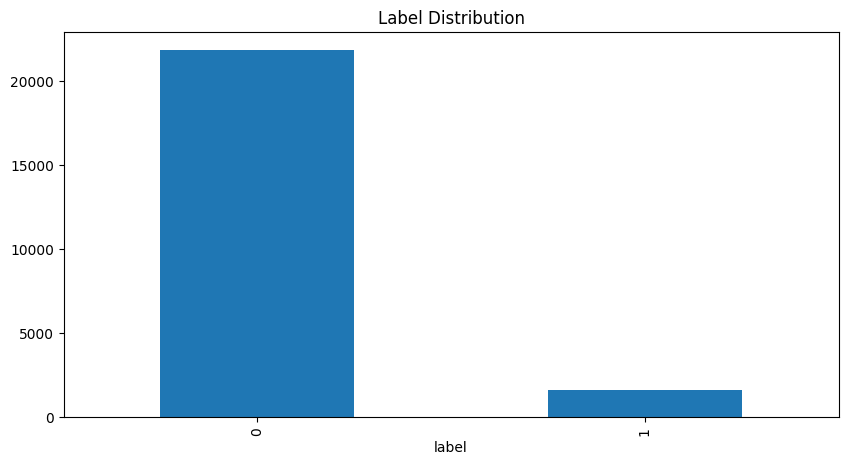

In [17]:
train_combined['label'].value_counts().plot(kind='bar', title='Label Distribution', figsize=(10, 5))
# df_cleaned['label'].value_counts(normalize=True).plot(kind='bar', title='Label Distribution (Normalized)', figsize=(10, 5))

### Preprocessing

In [18]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 fix_encoding=True, 
                 remove_hashtags=True, 
                 remove_mentions=True, 
                 remove_punctuation=True, 
                 lowercase=True, 
                 remove_stopwords=True, 
                 remove_urls=True, 
                 lemmatize=False, 
                 stem=True,
                 replace_slang=True,
                 remove_numbers=True,
                 remove_stock_symbols=True):
        
        self.fix_encoding = fix_encoding
        self.remove_hashtags = remove_hashtags
        self.remove_mentions = remove_mentions
        self.remove_punctuation = remove_punctuation
        self.lowercase = lowercase
        self.remove_stopwords = remove_stopwords
        self.remove_urls = remove_urls
        self.lemmatize = lemmatize
        self.stem = stem
        self.replace_slang = replace_slang
        self.remove_numbers = remove_numbers
        self.remove_stock_symbols = remove_stock_symbols
        
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        if not isinstance(text, str):
            return ''
        
        if self.fix_encoding:
            text = self._fix_encoding(text)
        if self.lowercase:
            text = text.lower()
        if self.replace_slang:
            text = self._replace_slang(text)
        if self.remove_urls:
            text = self._remove_urls(text)
        if self.remove_hashtags:
            text = self._remove_hashtags(text)
        if self.remove_mentions:
            text = self._remove_mentions(text)
        if self.remove_punctuation:
            text = self._remove_punctuation(text)
        if self.remove_numbers:
            text = re.sub(r'\d+', '', text)
        if self.remove_stock_symbols:
            text = re.sub(r'\$\w+', '', text)

        words = text.split()
        if self.remove_stopwords:
            words = [w for w in words if w not in self.stop_words]
        if self.lemmatize:
            words = [self.lemmatizer.lemmatize(w) for w in words]
        if self.stem:
            words = [self.stemmer.stem(w) for w in words]

        return ' '.join(words)

    def _fix_encoding(self, text):
        return text.encode("ascii", "ignore").decode()

    def _replace_slang(self, text):
        slang_dict = {
            r'\bur\b': 'your',
            r'\bu\b': 'you',
            r'\bgr8\b': 'great',
            r'\b4u\b': 'for you',
            # r'\blol\b': 'laughing out loud'
        }
        for slang, replacement in slang_dict.items():
            text = re.sub(slang, replacement, text)
        return text
    

    def _remove_urls(self, text):
        return re.sub(r'https?://\S+|www\.\S+', '', text)

    def _remove_hashtags(self, text):
        return re.sub(r'#', '', text)
    
    def _remove_mentions(self, text):
        return re.sub(r'@\w+', '', text)
    
    def _remove_punctuation(self, text):
        return re.sub(r'[^\w\s]', '', text)


In [19]:
# train_data_copied = train_combined.copy()

In [20]:
# preprocessor = TextPreprocessor()

# train_data_copied['tweet'] = preprocessor.fit_transform(train_data_copied['tweet'])

# train_data_copied['tweet'].head(10)

In [21]:
train_combined['tweet'].apply(lambda x: len(x.split())).describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    23434.000000
mean        13.522275
std         20.073546
min          1.000000
25%          9.000000
50%         13.000000
75%         17.000000
90%         21.000000
95%         23.000000
99%         26.000000
max       2607.000000
Name: tweet, dtype: float64

#### most of the sentences length is 26 word and there is an outline with 2607 

- I will set max_len = 30 because it is a good balance as it:

1. Covers nearly all data

2. Avoids wasting memory on rare long outliers

3. Keeps model efficient

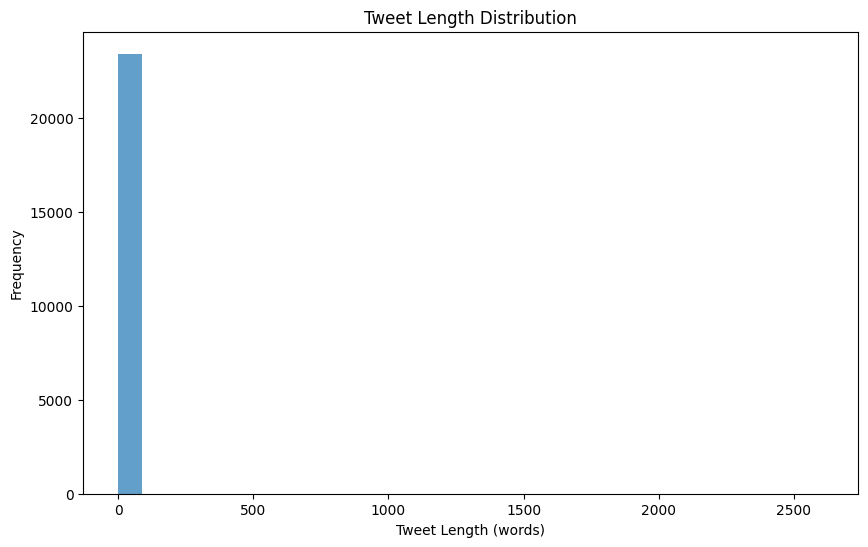

In [22]:
plt.figure(figsize=(10, 6))
train_combined['tweet'].apply(lambda x: len(x.split())).plot(kind='hist', bins=30, alpha=0.7)
plt.xlabel("Tweet Length (words)")
plt.ylabel("Frequency")
plt.title("Tweet Length Distribution")
plt.show()


In [23]:
# class TextTokenizer(BaseEstimator, TransformerMixin):
#     def __init__(self, num_words=50_000, max_len=30, oov_token="<OOV>"):
#         self.num_words = num_words
#         self.max_len = max_len
#         self.oov_token = oov_token
#         self.tokenizer = None

#     def fit(self, X, y=None):
#         self.tokenizer = Tokenizer(num_words=self.num_words, oov_token=self.oov_token)
#         self.tokenizer.fit_on_texts(X)
#         return self

#     def transform(self, X):
#         sequences = self.tokenizer.texts_to_sequences(X)
#         padded = pad_sequences(sequences, maxlen=self.max_len, padding='post', truncating='post')
#         return padded

#     def fit_transform(self, X, y=None):
#         return self.fit(X).transform(X)


In [24]:
class TextTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, num_words=50_000, oov_token="<OOV>"):
        self.num_words = num_words
        self.oov_token = oov_token
        self.tokenizer = None

    def fit(self, X):
        self.tokenizer = Tokenizer(num_words=self.num_words, oov_token=self.oov_token)
        self.tokenizer.fit_on_texts(X)
        return self

    def transform(self, X):
        return self.tokenizer.texts_to_sequences(X)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [25]:
class SequencePadder(BaseEstimator, TransformerMixin):
    def __init__(self, max_len=30, padding='post', truncating='post'):
        self.max_len = max_len
        self.padding = padding
        self.truncating = truncating

    def fit(self):
        return self  

    def transform(self, X):
        return pad_sequences(X, maxlen=self.max_len, padding=self.padding, truncating=self.truncating)

    def fit_transform(self, X, y=None):
        return self.transform(X)

Options for how to pad or truncate sequences:

- padding='post':
➤ Adds zeros at the end of sequences that are too short.
Example: [4, 6] → [4, 6, 0, 0] if max_len=4

- truncating='post':
➤ Cuts extra tokens from the end of sequences that are too long.
Example: [1, 5, 7, 8, 9] → [1, 5, 7, 8] if max_len=4

👉 Both make sure all sequences are exactly max_len long.
Using 'post' is common and works well for most tasks.

In [26]:
tokenizer = TextTokenizer(num_words=50_000, oov_token="<OOV>")
X_train_tokenized = tokenizer.fit_transform(X_train['tweet'])
X_test_tokenized = tokenizer.transform(X_test['tweet'])

In [27]:
# print([tokenizer.index_word[i] for i in [18, 5222, 2479, 1799, 127, 5222, 189]]) # example of word indices
# print([tokenizer.index_word[i] for i in [6, 4510, 1941, 25, 98, 424, 29, 860, 6208, 3572, 6209, 1, 7861]]) # example of word indices

In [28]:
# # Word2Vec GoogleNews (300d)
# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
# !gunzip GoogleNews-vectors-negative300.bin.gz

# # GloVe (100d)
# !wget -c "http://nlp.stanford.edu/data/glove.6B.zip"
# !unzip -o glove.6B.zip

# # FastText (300d)
# !wget -c "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz"
# !gunzip cc.en.300.vec.gz


### Modelling

In [ ]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

#### Embeddings implementation

In [29]:
def load_glove_embeddings(file_path, tokenizer):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe embeddings"):
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    word_index = word_index = tokenizer.tokenizer.word_index

    embedding_matrix = np.zeros((len(word_index) + 1, 100))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_fasttext_embeddings(file_path, tokenizer):
    embeddings_index = {}
    with open(file_path, 'rb') as f:
        for line in tqdm(f, desc="Loading FastText embeddings"):
            values = line.split()
            word = values[0].decode('utf-8')
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    word_index = word_index = tokenizer.tokenizer.word_index

    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_word2vec_embeddings(file_path, tokenizer):
    word2vec = KeyedVectors.load_word2vec_format(file_path, binary=True)
    word_index = word_index = tokenizer.tokenizer.word_index

    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        if word in word2vec:
            embedding_matrix[i] = word2vec[word]
    return embedding_matrix


glove_embeddings = load_glove_embeddings('glove.6B.100d.txt', tokenizer)

fasttext_embeddings = load_fasttext_embeddings('cc.en.300.vec', tokenizer)

Loading GloVe embeddings: 0it [00:00, ?it/s]

Loading GloVe embeddings: 400000it [00:13, 30461.06it/s]
Loading FastText embeddings: 2000001it [01:04, 31045.01it/s]


In [32]:
# word2vec_embeddings = load_word2vec_embeddings('GoogleNews-vectors-negative300.bin', tokenizer)

: 

#### Simple RNN

In [104]:
# # Create a generic RNN model function for binary classification
# from tensorflow.keras.layers import SimpleRNN

# def create_rnn_model(embedding_matrix, max_len=30, rnn_units=64, dense_units=[64], trainable_embeddings=False):
#     model = Sequential()
#     model.add(Input(shape=(max_len,)))
#     model.add(Embedding(input_dim=embedding_matrix.shape[0], 
#                         output_dim=embedding_matrix.shape[1], 
#                         weights=[embedding_matrix], 
#                         trainable=trainable_embeddings))
    
#     model.add(SimpleRNN(rnn_units))  # <-- this processes the sequence into 1 vector
    
#     for units in dense_units:
#         model.add(Dense(units, activation='relu'))
    
#     model.add(Dense(1, activation='sigmoid'))  # Final binary output
    
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model


#### LSTM 

In [105]:
LSTM_Model = Sequential()
LSTM_Model.add(Input(shape=(30,)))
LSTM_Model.add(Embedding(input_dim=glove_embeddings.shape[0], 
                        output_dim=glove_embeddings.shape[1], 
                        weights=[glove_embeddings], 
                        trainable=False))
LSTM_Model.add(LSTM(64, return_sequences=True))
LSTM_Model.add(LSTM(32))
LSTM_Model.add(Dense(64, activation='relu'))
LSTM_Model.add(Dense(1, activation='sigmoid'))  # Final binary output
LSTM_Model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTM_Model.summary()

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_39 (Embedding)        │ (None, 30, 100)        │     4,008,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,065,433 (15.51 MB)

 Trainable params: 56,833 (222.00 KB)

 Non-trainable params: 4,008,600 (15.29 MB)

In [106]:
pipeline_glove = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('tokenizer', TextTokenizer(num_words=50_000, oov_token="<OOV>")),
    ('padder', SequencePadder(max_len=30)),
    ('smote', SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)),
    ('model', LSTM_Model)
])

In [107]:
pipeline_glove.fit(X_train['tweet'], y_train, model__epochs=50, model__batch_size=32)

Epoch 1/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9020 - loss: 0.3329
Epoch 2/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9081 - loss: 0.3086
Epoch 3/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9100 - loss: 0.3038
Epoch 4/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9102 - loss: 0.3027
Epoch 5/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9112 - loss: 0.2962
Epoch 6/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9082 - loss: 0.2813
Epoch 7/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9088 - loss: 0.2649
Epoch 8/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9075 - loss: 0.2521
Epoch 9/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9190 - loss: 0.2295
Epoch 10/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9308 - loss: 0.2100
Epoch 11/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9334 - loss: 0.1992
Epoch 12/50
751/751 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

In [81]:
predictions = pipeline_glove.predict(X_test['tweet'])
binary_predictions_glove_RNN = (predictions > 0.5).astype(int)  # Convert to binary
print(classification_report(y_test, binary_predictions_glove_RNN))
print("Accuracy:", accuracy_score(y_test, binary_predictions_glove_RNN))


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/home/israa/.local/lib/python3.10/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(


In [100]:
pipeline_fasttext = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('tokenizer', TextTokenizer(num_words=50_000, oov_token="<OOV>")),
    ('padder', SequencePadder(max_len=30)),
    ('smote', SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)),
    ('model', create_rnn_model(fasttext_embeddings, max_len=30, dense_units=[128, 64], trainable_embeddings=False))
])

In [101]:
pipeline_fasttext.fit(X_train['tweet'], y_train, model__epochs=20, model__batch_size=32)

Epoch 1/20
751/751 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9062 - loss: 0.3253
Epoch 2/20
751/751 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9061 - loss: 0.3141
Epoch 3/20
751/751 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9068 - loss: 0.3115
Epoch 4/20
751/751 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9098 - loss: 0.3046
Epoch 5/20
751/751 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9097 - loss: 0.3057
Epoch 6/20
751/751 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9088 - loss: 0.3065
Epoch 7/20
751/751 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9076 - loss: 0.3090
Epoch 8/20
751/751 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9074 - loss: 0.3098
Epoch 9/20
751/751 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9071 - loss: 0.3094
Epoch 10/20
751/751 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9113 - loss: 0.3003
Epoch 11/20
751/751 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9107 - loss: 0.3020
Epoch 12/20
751/751 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('tokenizer', TextTokenizer()), ('padder', SequencePadder()),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('model', <Sequential name=sequential_37, built=True>)])

In [102]:
predictions = pipeline_fasttext.predict(X_test['tweet'])
binary_predictions_fasttext_RNN = (predictions > 0.5).astype(int)  # Convert to binary
print(classification_report(y_test, binary_predictions_fasttext_RNN, target_names=['Non-Hate', 'Hate']))
print("Accuracy:", accuracy_score(y_test, binary_predictions_fasttext_RNN))

189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

    Non-Hate       0.93      1.00      0.96      5610
        Hate       0.00      0.00      0.00       417

    accuracy                           0.93      6027
   macro avg       0.47      0.50      0.48      6027
weighted avg       0.87      0.93      0.90      6027

Accuracy: 0.9308113489298159


/home/israa/.local/lib/python3.10/site-packages/imblearn/pipeline.py:65: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 0.15 instead of the current warning.
  warnings.warn(
/home/israa/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/israa/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/israa/.local/lib/python3.10/site-p

#### Evaluation

In [82]:
print(classification_report(y_test, binary_predictions_glove_RNN))
print("Accuracy:", accuracy_score(y_test, binary_predictions_glove_RNN))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5610
           1       0.00      0.00      0.00       417

    accuracy                           0.93      6027
   macro avg       0.47      0.50      0.48      6027
weighted avg       0.87      0.93      0.90      6027

Accuracy: 0.9308113489298159


/home/israa/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/israa/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/israa/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [86]:
print(classification_report(y_test, binary_predictions_fasttext_RNN))
print("Accuracy:", accuracy_score(y_test, binary_predictions_fasttext_RNN))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5610
           1       0.52      0.06      0.10       417

    accuracy                           0.93      6027
   macro avg       0.73      0.53      0.53      6027
weighted avg       0.91      0.93      0.90      6027

Accuracy: 0.9311431889829103


### Enhancement

### Results & Conclusion

#### Done!